# IMDB Sentiment Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [2]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        model.fit(X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

def sampling_methods(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    return (X_res, y_res)

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/Cleaned.csv", nrows=20000)
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter mattei s love in the time of money is...,positive
...,...,...
19995,ok for starters taxi driver is amazing this...,negative
19996,it is sort of hard for me to say it because i...,negative
19997,i still liked it though warren beatty is only...,positive
19998,we could still use black adder even today ima...,positive


# Check for Nulls and Dupes

In [5]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: review       0
sentiment    0
dtype: int64
Dupe Count: 74


In [6]:
df[df.duplicated()]

,review,sentiment
3537,quite what the producers of this appalling ada...,negative
3769,my favourite police series of all time turns t...,positive
4391,beautiful film pure cassavetes style gena ro...,positive
6352,if you liked the grinch movie go watch that...,negative
6479,i want very much to believe that the above quo...,negative
...,...,...
19720,the problem with so many people watching this ...,positive
19827,goodnight mister tom begins in an impossibly ...,negative
19861,this movie starts out as if it were a comedy ...,negative
19890,humm an italian movie starred by david hassel...,negative


In [7]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

Class=positive, Count=9880, Percentage=49.583%
Class=negative, Count=10046, Percentage=50.417%


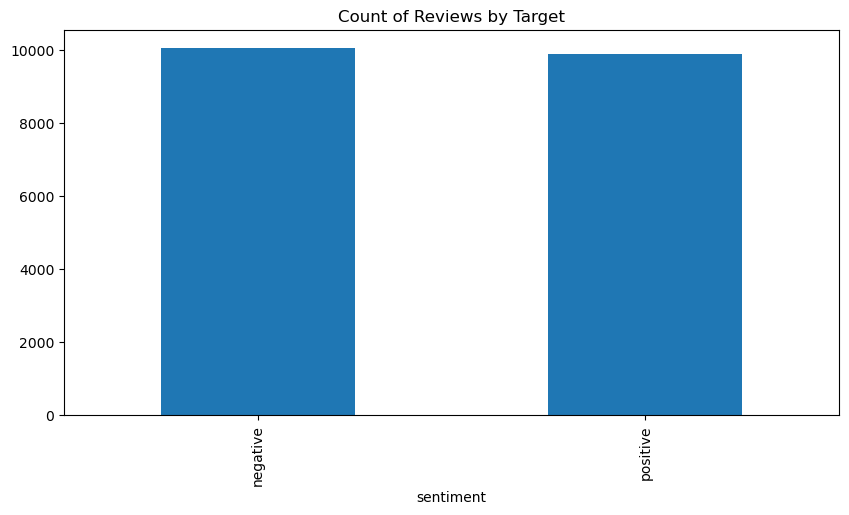

In [8]:
check_class_imbalance(df,df['sentiment'],'sentiment')

In [9]:
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

In [11]:
df['len_text'] = df['review'].apply(lambda x: len(x))
df['num_words'] = df['review'].apply(lambda x: len(x.split())) 